<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/Autoencoder-demo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder - 01418496 (หมู่เรียน 200)

In [111]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
tf.__version__

'2.17.1'

In [112]:
import numpy as np
from PIL import Image

### Setting to execute on Processor (GPU or CPU)

In [113]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on GPU


### Download Dataset

In [114]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("tongpython/cat-and-dog/version/1")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing


In [115]:
dataset_path = "./dataset"
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Path: {dirpath}, Subdirectories: {dirnames}, Files: {len(filenames)}")

Path: ./dataset, Subdirectories: ['training_set', 'test_set'], Files: 0
Path: ./dataset/training_set, Subdirectories: ['training_set'], Files: 0
Path: ./dataset/training_set/training_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/training_set/training_set/dogs, Subdirectories: [], Files: 4006
Path: ./dataset/training_set/training_set/cats, Subdirectories: [], Files: 4001
Path: ./dataset/test_set, Subdirectories: ['test_set'], Files: 0
Path: ./dataset/test_set/test_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/test_set/test_set/dogs, Subdirectories: [], Files: 1013
Path: ./dataset/test_set/test_set/cats, Subdirectories: [], Files: 1012


In [116]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0  # Normalize pixel values to [0, 1]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    return imgs

def to_image(img):
    img = np.squeeze(img)
    return Image.fromarray(np.uint8(img * 255))

In [117]:
import cv2
def dataset_to_numpy_and_preprocess(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    imgs = np.concatenate(images)
    lbls = np.concatenate(labels)
    return preprocess(imgs), lbls

def change_gray_images(images):
    gray_images = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(image)

    gray_images = np.array(gray_images)
    gray_images = np.repeat(gray_images[:, :, :, np.newaxis], 3, axis=3)  # Repeat across the 3rd axis
    return gray_images

In [118]:
train_dir = "./dataset/training_set/training_set"
test_dir = "./dataset/test_set/test_set"

In [119]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(50, 50),  # Resize images
    batch_size=32,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(50, 50),
    batch_size=32,
)

X_train, y_train = dataset_to_numpy_and_preprocess(train_dataset)
X_test, y_test = dataset_to_numpy_and_preprocess(test_dataset)
X_train_gray = change_gray_images(X_train)
X_test_gray = change_gray_images(X_test)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [120]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
SHAPE = X_train.shape[1:]
print(f"Shape: {SHAPE}")

X_train shape: (8005, 54, 54, 3)
y_train shape: (8005,)
X_test shape: (2023, 54, 54, 3)
y_test shape: (2023,)
Shape: (54, 54, 3)


In [121]:
print(f"X_train_gray: {X_train_gray.shape}")
print(f"X_test_gray: {X_test_gray.shape}")
NEW_SHAPE = X_train_gray.shape[1:]
print(f"New Shape: {NEW_SHAPE}")

X_train_gray: (8005, 54, 54, 3)
X_test_gray: (2023, 54, 54, 3)
New Shape: (54, 54, 3)


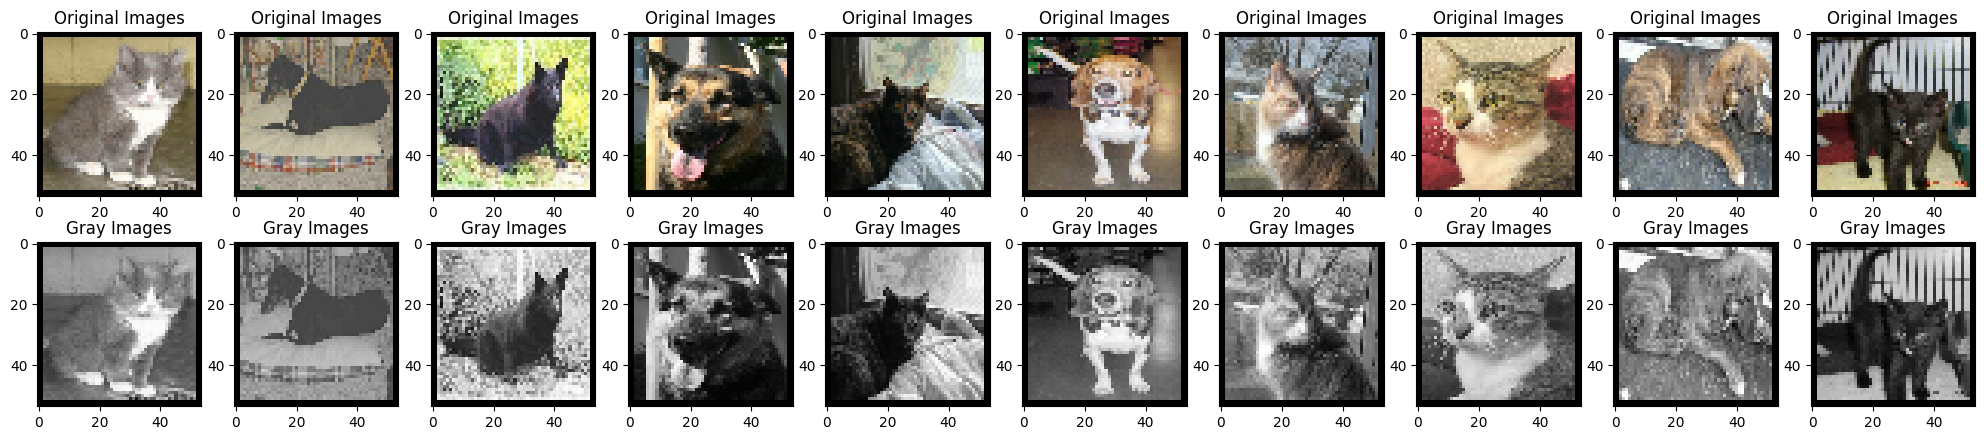

In [122]:
num_images = 10
fig = plt.figure(figsize=(25, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i])
    plt.title("Original Images")

    plt.subplot(2, 10, i+1+num_images)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.title("Gray Images")

### Create Model by using OOP

In [123]:
from tensorflow.keras import Model, layers, losses, activations, optimizers

class Autoencoder(Model):
  def __init__(self, latent_dim:int, shape:tuple):
    super(Autoencoder, self).__init__()
    self.shape = shape
    self.latent_dim = latent_dim

    self.encoder = tf.keras.Sequential([
      layers.InputLayer(shape=shape, name="Encoder_Input"),
      layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=activations.relu, strides=2),
      layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation=activations.relu),
      layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation=activations.relu),
    ])

    print(self.encoder.layers[2])
    print(self.encoder.layers[2].input.shape)
    print(self.encoder.layers[2].output.shape)

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", activation=activations.relu),
      layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", activation=activations.relu),
      layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", activation=activations.relu, strides=2),
      layers.Conv2D(filters=shape[-1], kernel_size=(3, 3), padding="same", activation=activations.sigmoid)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [124]:
autoencoder = Autoencoder(10, SHAPE)

<Conv2D name=conv2d_48, built=True>
(None, 27, 27, 64)
(None, 27, 27, 32)


In [125]:
autoencoder.encoder.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 27, 27, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 27, 27, 32)          │          18,464 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,840 (374.38 KB)

 Trainable params: 95,840 (374.38 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
autoencoder.decoder.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_31                  │ ?                           │     0 (unbuilt) │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_32                  │ ?                           │     0 (unbuilt) │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_33                  │ ?                           │     0 (unbuilt) │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [127]:
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss=losses.MeanSquaredError())

In [128]:
autoencoder.fit(X_train_gray, X_train, epochs=50, validation_data=(X_test, X_test), batch_size=32)

Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0383 - val_loss: 0.0084
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 9/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 10/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 11/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0049 - val_loss: 0.0089
Epoch 12/50
251/251 ━━━━━━━━━━━━━━━━━━━━

In [129]:
autoencoder.encoder.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_46 (Conv2D)                   │ (None, 27, 27, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 27, 27, 32)          │          18,464 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,840 (374.38 KB)

 Trainable params: 95,840 (374.38 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
autoencoder.decoder.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_31                  │ (None, 27, 27, 32)          │           9,248 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_32                  │ (None, 27, 27, 64)          │          18,496 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_33                  │ (None, 54, 54, 128)         │          73,856 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 54, 54, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,059 (410.39 KB)

 Trainable params: 105,059 (410.39 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
encoded_imgs = autoencoder.encoder(X_test_gray)
decoded_imgs = autoencoder.decoder(encoded_imgs)

In [132]:
prediction = autoencoder.predict(X_test_gray)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


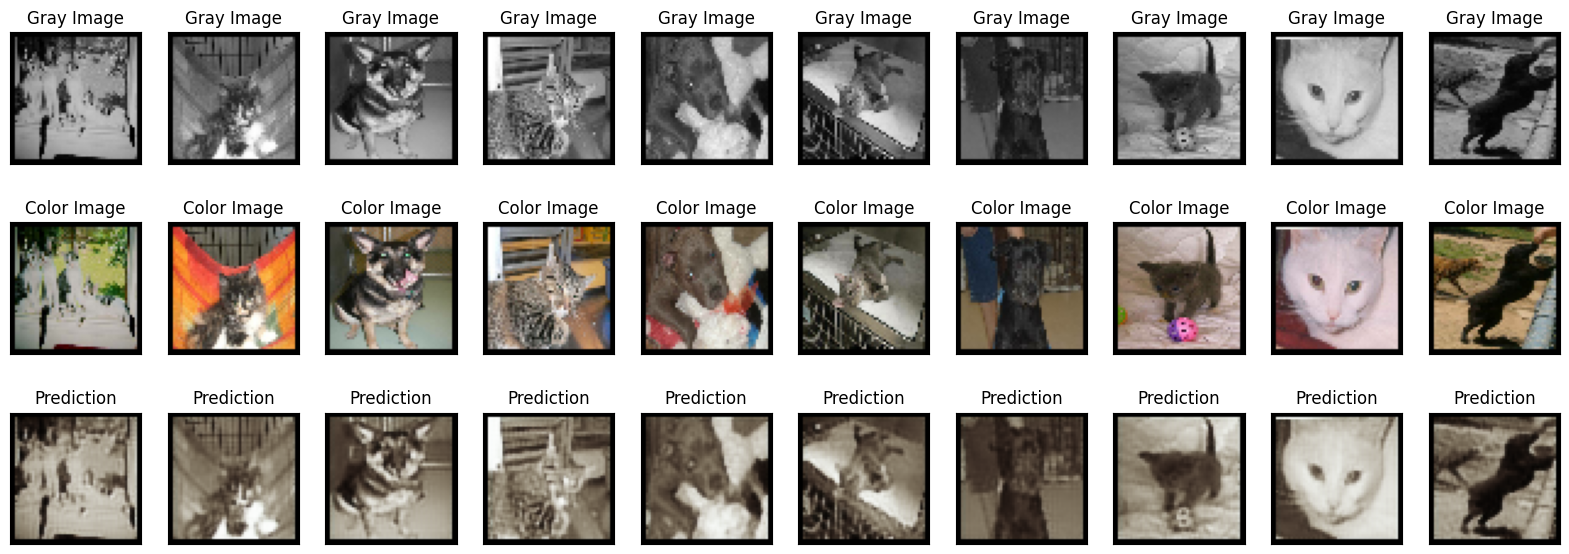

In [133]:
n = 10
plt.figure(figsize=(20, 7))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_gray[i])
    plt.title("Gray Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(X_test[i])
    plt.title("Color Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(prediction[i])
    plt.title("Prediction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [134]:
encoded_imgs

<tf.Tensor: shape=(2023, 27, 27, 32), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.4796483 , ..., 0.        ,
          0.3185687 , 0.        ],
         [0.        , 0.        , 0.4747941 , ..., 0.        ,
          0.4264617 , 0.        ],
         [0.        , 0.        , 0.42080534, ..., 0.        ,
          0.27205676, 0.        ],
         ...,
         [0.        , 0.        , 0.33366   , ..., 0.        ,
          0.97444636, 0.        ],
         [0.        , 0.        , 0.3268003 , ..., 0.        ,
          1.3704197 , 0.        ],
         [0.        , 0.        , 0.46303976, ..., 0.        ,
          0.5138909 , 0.        ]],

        [[0.        , 0.        , 0.45580184, ..., 0.        ,
          0.17243989, 0.        ],
         [0.        , 0.        , 0.74188185, ..., 0.        ,
          0.4361024 , 0.        ],
         [0.        , 0.        , 0.3801914 , ..., 0.        ,
          0.22806938, 0.        ],
         ...,
         [0.        , 0.    